Thie notebook explores a Butler data repository and retrieve relevant eotest results. The `obs_lsst` package is required.

In [1]:
! eups list -s lsst_distrib

   16.0-1-g3bbe181+31 	current w_2018_45 setup


In [ ]:
import eups
assert eups.getSetupVersion("lsst_distrib")
print(eups.getSetupVersion("obs_lsst"))

In [2]:
import lsst.afw.detection as afwDetection
from lsst.daf.persistence import Butler

import matplotlib.pyplot as plt
import numpy

In [3]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
# Look up what runs are available
runs = butler.queryMetadata('raw', ['run'], dataId={'imageType': 'FE55', 'testType': 'FE55'})
print("Available runs: ", runs)
# Look up what visits are available in this run
print("Available visits: ", butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FE55', 'testType': 'FE55', 'run': '7086' }))

# The old obs_lsst had a bug, so the dataId 'detector' was used instaed of 'detectorName'
# As of Nov 15, the new master of obs_lsst allow us to use `detectorName`
dId = {'visit': 258334666, 'detectorName': 'S00'}
raw = butler.get('raw', **dId)

# The following does not work at this moment; bug DM-16553 has been filed
#bias = butler.get('bias', visit=258334666, detectorName='S00')
# Use 'detector' before the bug is fixed
bias = butler.get('bias', visit=258334666, detector=0)

# One way to know which file this is:
#print(butler.get('raw_filename', **dId))

Available runs:  ['7086']
Available visits:  [258334666, 258334978, 258335291, 258335602, 258335913]


In [ ]:
# Alternatively, one can use butler subset feature 
# To match the same queryMetadata condition in the above cell
dataId = {'run': '7086', 'detectorName': 'S00', 'imageType': 'FE55', 'testType': 'FE55'}
subset = butler.subset("raw", **dataId)
print(len(subset))

n = 0
for ref in subset:
    print(ref.get("raw"))
    print(ref.dataId)
    # or more complicated operation can be done here
    n += 1
    if n > 3:
        break

In [4]:
# Another way to get the detector name
raw.getDetector().getName()

'R00_S00'

In [5]:
raw.getDetector().getSerial()

'E2V-CCD250-266-Dev'

In [6]:
# hard-coded gains in the camera definition inside obs_lsst
gains = [ccd.getGain() for ccd in raw.getDetector()]
print(gains)

[1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7]


To get EO test results from database, install the following packages to your area:

```
git clone https://github.com/lsst-camera-dh/eTraveler-clientAPI.git
git clone https://github.com/lsst-camera-dh/datacat-utilities.git 
cd datacat-utilities
git checkout python3
```

As of Nov 15, one need comment out all imports of `datacat` in `python/DataCatalog.py`; `datacat` is not needed to get the EO test results.


edit $HOME/notebooks/.user_setups with:

```
export PYTHONPATH=$PYTHONPATH:/path/to/eTraveler-clientAPI/python
export PYTHONPATH=$PYTHONPATH:/path/to/datacat-utilities/python
```

In [7]:
from get_EO_analysis_results import get_EO_analysis_results
from get_EO_analysis_files import get_EO_analysis_files
from exploreFocalPlane import exploreFocalPlane
from exploreRaft import exploreRaft
from eTraveler.clientAPI.connection import Connection

In [ ]:
# Get EO analysis results access results from the eTraveler database
g = get_EO_analysis_results(db='Dev')

In [ ]:
# Some examples of getting eotest results
raft_list, data = g.get_tests(site_type="I&T-Raft", test_type="bright_columns", run ='5943D')  # get the data for I&T-Raft
res = g.get_results(test_type='bright_columns', data=data, device=raft_list[0])  # get the data for a raft

raft_list, data = g.get_tests(site_type="I&T-Raft", run ='5943D')
res = g.get_all_results(data=data, device=raft_list)
res.keys()

In [8]:
# run numbers ending with 'D' is in the 'Dev' db
# run numbers ending without 'D' is in the 'Prod' db
g_prod = get_EO_analysis_results(db='Prod')
# Here we ask for the same run as the data in the Butler repo
raft_list, data = g_prod.get_tests(site_type="I&T-Raft", run ='7086')
res = g_prod.get_all_results(data=data, device=raft_list)

In [9]:
res['gain'].keys()

dict_keys(['E2V-CCD250-260', 'E2V-CCD250-182', 'E2V-CCD250-175', 'E2V-CCD250-167', 'E2V-CCD250-195', 'E2V-CCD250-201', 'E2V-CCD250-222', 'E2V-CCD250-213', 'E2V-CCD250-177'])

Wait... The ccd names are different from those obtained from `exposure.getDetector().getSerial()`! But it can be found by `exposure.getMetadata().getScalar('LSST_NUM')`

---> See ChrisW's notebook `czw_butlerEOqueries.ipynb` for more exploration!

In [ ]:
print(raw.getMetadata().getScalar('LSST_NUM'))

In [ ]:
ccd_name = 'E2V-CCD250-260'
res['gain'][ccd_name]

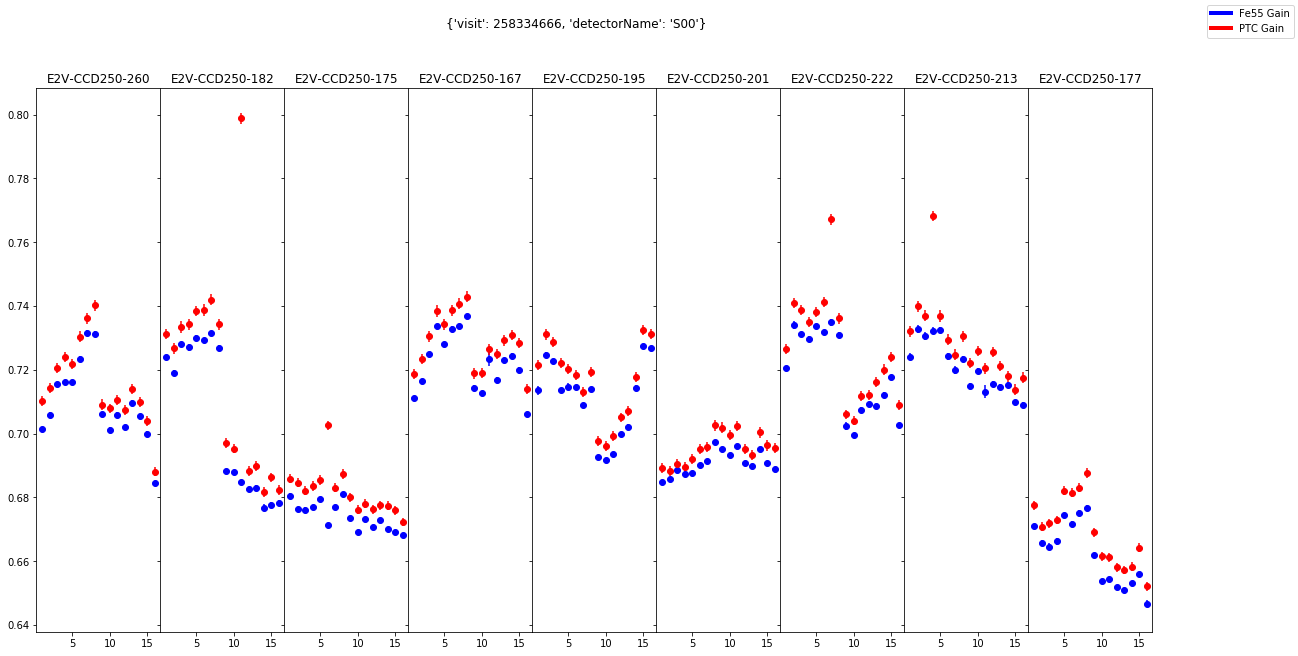

In [10]:
fig, axs = plt.subplots(1, 9, figsize=(20, 10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
for i, ccd in enumerate(res['gain']):
    p = axs[i]
    p.set_title(ccd)
    p.errorbar(range(1,17),res['gain'][ccd],yerr=res['gain_error'][ccd],color='blue',label='Fe55 Gain', fmt='o')
    p.errorbar(range(1,17),res['ptc_gain'][ccd],yerr=res['ptc_gain_error'][ccd],color='red',label='PTC Gain', fmt='o')


from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4)]
fig.legend(custom_lines, ['Fe55 Gain', 'PTC Gain'])
fig.suptitle(str(dId), fontsize=12)
fig.savefig("plot.png")

### To make a mosaic plot using eotest

To use eotest, clone the package from https://github.com/lsst-camera-dh/eotest to local, add `setup -j -r path/to/eotest` to `${HOME}/notebooks/.user_setups` and restart the notebook kernel.

In [ ]:
! eups list -s eotest

In [11]:
import lsst.eotest.raft as raftTest

In [ ]:
import os
import glob

In [12]:
visit = 258334666

In [ ]:
# Use file names
infiles = sorted(glob.glob(os.path.join("/project/bootcamp/repo_RTM-007/raw/7086/",
                                        "*"+str(visit)+"*")))

file_dict = {filename.split('-')[-2]: filename for filename in infiles}
print(file_dict)

In [13]:
# Alternatively, use Butler
subset = butler.subset("raw", visit=visit)
assert(len(subset)==9)
file_dict = {ref.dataId['detectorName']: ref.get("raw_filename")[0][:-3] for ref in subset}

/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


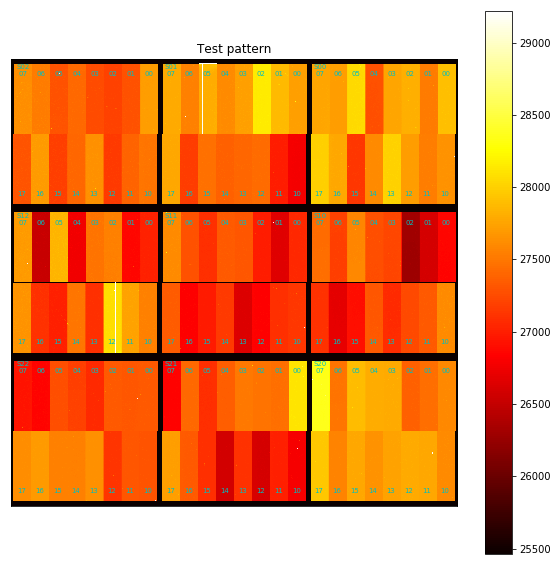

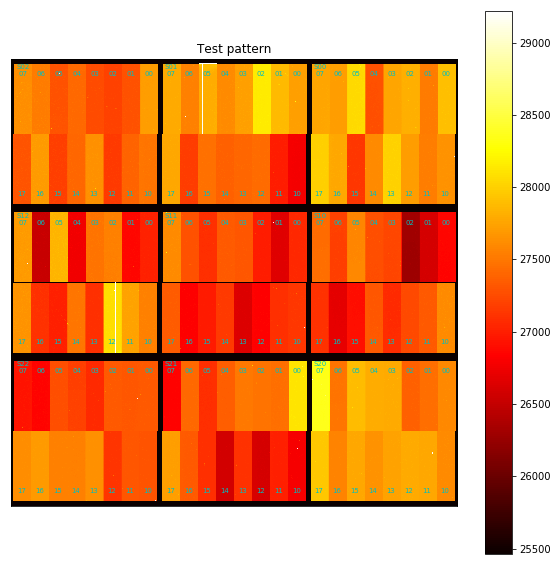

In [14]:
raft_mosaic = raftTest.RaftMosaic(file_dict, bias_subtract=False)
raft_mosaic.plot(title='Test pattern')